<h1>CP467 - Project</h1>

<ol>
    <h2>Members:</h2>
    <li>Duc Minh Nguyen - 203009140 - ducx9140@mylaurier.ca</li>
    <li>Quang Quynh Anh Lam -</li>
    <li>Mohiuddin Usama - </li>
</ol>

<h2>Importing</h2>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import random

from sklearn.metrics import precision_recall_fscore_support
import matplotlib.patches as mpatches



colors = [
    (197, 215, 20),
    (132, 248, 207),
    (155, 244, 183),
    (111, 71, 144),
    (71, 48, 128),
    (75, 158, 50),
    (37, 169, 241),
    (51, 181, 222),
    (161, 104, 244),
    (226, 133, 31),
    (7, 47, 204),
    (0, 252, 170),
    (124, 166, 32),
    (97, 113, 122),
    (72, 229, 46),
    (41, 163, 250),
    (55, 154, 149)
]

<h2>Load Image</h2>

In [27]:
scene_dict = {
#  'Scene_1': 'S1.png',
#  'Scene_2': 'S2.png',
#  'Scene_3': 'S3.png',
#  'Scene_4': 'S4.png',
#  'Scene_5': 'S5.png',
#  'Scene_6': 'S6.png',
#  'Scene_7': 'S7.png',
#  'Scene_8': 'S8.png',
#  'Scene_9': 'S9.png',
#  'Scene_10': 'S10.png',
#  'Scene_11': 'S11.png',
#  'Scene_12': 'S12.png',
#  'Scene_13': 'S13.png',
#  'Scene_14': 'S14.png',
#  'Scene_15': 'S15.png',
#  'Scene_16': 'S16.png',
#  'Scene_17': 'S17.png',
#  'Scene_18': 'S18.png',
#  'Scene_19': 'S19.png',
#  'Scene_20': 'S20.png',
#  'Scene_21': 'S21.png',
#  'Scene_22': 'S22.png',
#  'Scene_23': 'S23.png',
#  'Scene_24': 'S24.png',
#  'Scene_25': 'S25.png',
#  'Scene_26': 'S26.png',
#  'Scene_27': 'S27.png',
 'Scene_28': 'S28.png'
}

object_dict = {
 'Object_1': 'O1.png',
 'Object_2': 'O2.png',
 'Object_3': 'O3.png',
 'Object_4': 'O4.png',
 'Object_5': 'O5.png',
 'Object_6': 'O6.png',
 'Object_7': 'O7.png',
 'Object_8': 'O8.png',
 'Object_9': 'O9.png',
 'Object_10': 'O10.png',
 'Object_11': 'O11.png',
 'Object_12': 'O12.png',
 'Object_13': 'O13.png',
 'Object_14': 'O14.png',
 'Object_15': 'O15.png',
 'Object_16': 'O16.png',
 'Object_17': 'O17.png'
}

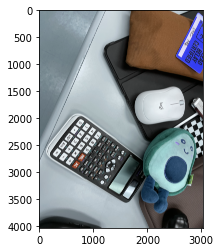

In [4]:
# Store path data for the object and scene
path_scene = "../../Scenes/"
path_object = "../../Objects/"

# Store image name and path into a dictionary for further implementation
object_image_paths = ['path_to_object_image_1.png', 'path_to_object_image_2.png', ...]
scene_image_paths = ['path_to_scene_image_1.png', 'path_to_scene_image_2.png', ...]

# TESTING DATA
object1 = cv2.imread( (str(path_object) + (object_dict["Object_1"])) )
scene1 = cv2.imread( (str(path_scene) + (scene_dict["Scene_17"])) )

scene1 = cv2.GaussianBlur(scene1, (5,5), 0)

plt.imshow(scene1)

<h2>Task 1</h2>

Not enough matches are found - 0/4
0 161


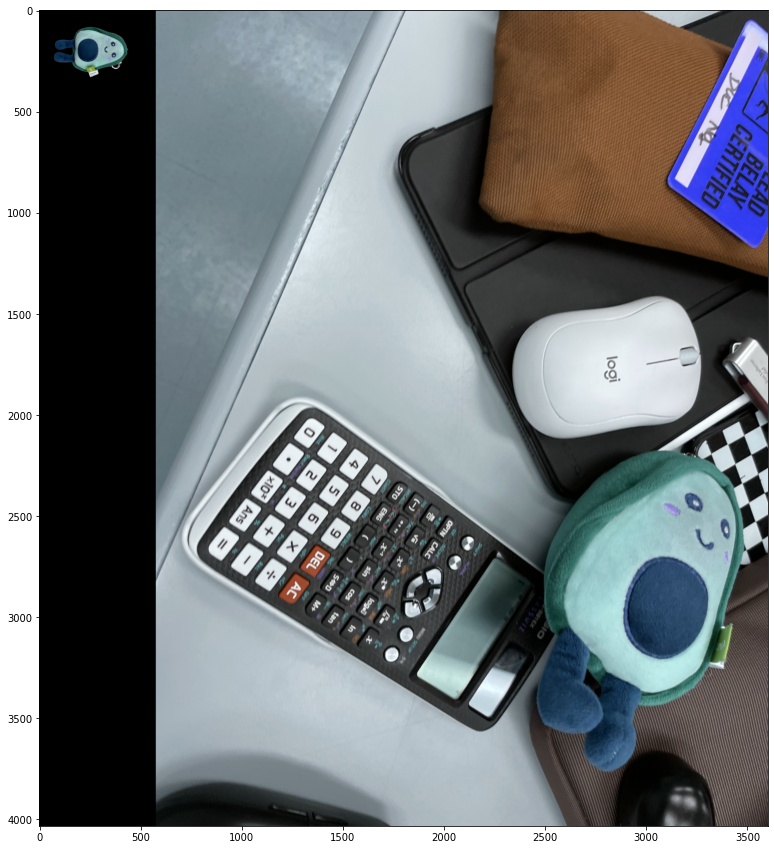

In [5]:
def draw_matches_with_boxes(object_image, scene_image):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints_object, descriptors_object = sift.detectAndCompute(object_image, None)
    keypoints_scene, descriptors_scene = sift.detectAndCompute(scene_image, None)

    # Initialize FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN
    matches = flann.knnMatch(descriptors_object, descriptors_scene, k=2)

    # Apply Lowe's ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.45 * n.distance:
            good_matches.append(m)

    # Find homography if enough good matches are detected
    if len(good_matches) > 4:
        # Prepare source and destination points
        src_pts = np.float32([keypoints_object[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Compute homography
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Get object image size
        h, w, _ = object_image.shape

        # Generate points for the corners of the object image
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

        # Apply homography to the points
        dst = cv2.perspectiveTransform(pts, M)

        # Draw bounding box
        scene_image_with_box = cv2.polylines(scene_image.copy(), [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

    else:
        print("Not enough matches are found - {}/{}".format(len(good_matches), 4))
        scene_image_with_box = scene_image.copy()

    # Draw matches
    matched_image = cv2.drawMatches(object_image, keypoints_object, scene_image_with_box, keypoints_scene, good_matches, None, flags=2)

    return matched_image, len(good_matches) , len(keypoints_object)


matched_img, good_matches, keypoints_object = draw_matches_with_boxes(object1, scene1)

print(good_matches, keypoints_object)

plt.figure(figsize=(15,15))
plt.imshow(matched_img)

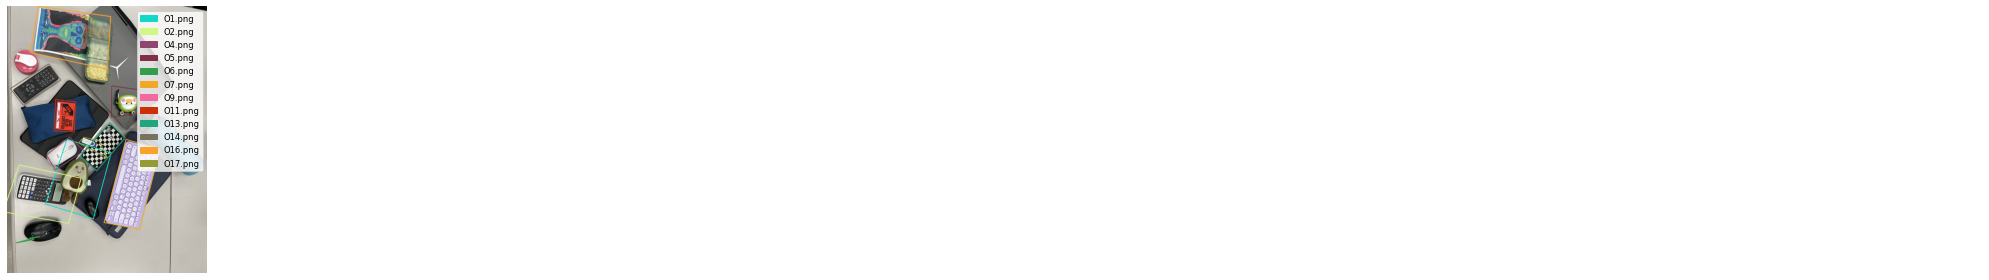



 {'Scene_28': {'Object_1', 'Object_4', 'Object_2', 'Object_13', 'Object_7', 'Object_5', 'Object_11', 'Object_14', 'Object_16', 'Object_9', 'Object_17', 'Object_6'}}
Scene_28 - Precision: 1.00, Recall: 0.71, F1-Score: 0.83, Accuracy: 0.71


In [28]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

# *example of ground truth
ground_truth = {}

# Assuming each scene has a consistent set of objects, but you can customize as needed
objects_in_scenes = {"Object_" + str(i) for i in range(1,18)}
# Generate ground truth data for scenes from 1 to 28
# for i in range(1, 2):
#     ground_truth[f'Scene_{i}'] = objects_in_scenes
ground_truth[f'Scene_28'] = objects_in_scenes

# ! NEW
def detect_and_draw_box_with_legend(object_img_path, scene_img, scene_keypoints, scene_descriptors, color, color_legend):
    object_img = cv2.imread(object_img_path)
    object_img_gray = cv2.cvtColor(object_img, cv2.COLOR_BGR2GRAY)
    object_keypoints, object_descriptors = sift.detectAndCompute(object_img_gray, None)
    matches = bf.knnMatch(object_descriptors, scene_descriptors, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    object_detected = False  # Initialize a flag for object detection

    if len(good_matches) > 4:
        src_pts = np.float32([object_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([scene_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is not None:
            h, w = object_img_gray.shape
            pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, M)
            scene_img = cv2.polylines(scene_img, [np.int32(dst)], True, color, 12, cv2.LINE_AA)
            color_legend.append((color, object_img_path.split('/')[-1]))
            object_detected = True  # Set the flag to True as the object is detected

    return scene_img, color_legend, object_detected



# Initialize color legend list
color_legend = []
scene_result = []
color_legend_result = []
count = 0

# *Initialize dictionary to store detection results for each scene
detected_objects = {scene: set() for scene in ground_truth}


# *Process each object image, draw boxes, and prepare the legend
for scene_name, scene_img_path in scene_dict.items() : 
    # Read scene from each scene
    scene = cv2.imread(path_scene + str(scene_dict[scene_name]) )

    # Reading scene keypoints and descriptors
    scene_keypoints, scene_descriptors = sift.detectAndCompute(scene, None)

    # Iterating through object dictionary list and detect whether they appear on the scne
    for object_name, object_img_path in object_dict.items():
        # Set up count to select each color box for each different objects
        color = colors[count % len(colors)]
        count += 1

        scene_img, color_legend, detected = detect_and_draw_box_with_legend(path_object + object_img_path, scene, scene_keypoints, scene_descriptors,color, color_legend)
        
        if detected:
            detected_objects[scene_name].add(object_name)
    scene_result.append(scene_img)
    color_legend_result.append(color_legend)
    color_legend =[]


# Calculate the number of rows needed for the subplot
num_scenes = len(scene_result)
num_columns = 4
num_rows = num_scenes // num_columns + (num_scenes % num_columns > 0)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, num_rows * 4))
# Flatten the axes array for easy iteration
axes = axes.flatten()

# Go through each scene and its corresponding legend
for i, (scene_img, color_legend) in enumerate(zip(scene_result, color_legend_result)):
    # Convert the image to RGB for displaying in Matplotlib
    scene_img_rgb = cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB)
    
    # Display the scene image
    axes[i].imshow(scene_img_rgb)
    axes[i].axis('off')  # Hide the axis
    
    # Create a list of patches for the legend
    legend_patches = [mpatches.Patch(color=np.array(color[::-1])/255, label=name) for color, name in color_legend]
    axes[i].legend(handles=legend_patches, loc='upper right', fontsize='small')

# Hide any remaining empty subplots
for j in range(i + 1, num_columns * num_rows):
    axes[j].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# * This function used to calculate_metrics
def calculate_metrics(TP, FP, FN, TN):
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    return precision, recall, f1_score, accuracy

for scene_name in ground_truth:
    print("\n\n" , detected_objects)
    TP = len(ground_truth[scene_name].intersection(detected_objects[scene_name]))
    FP = len(detected_objects[scene_name] - ground_truth[scene_name])
    FN = len(ground_truth[scene_name] - detected_objects[scene_name])
    TN = 0  # Typically not used in object detection

    precision, recall, f1_score, accuracy = calculate_metrics(TP, FP, FN, TN)
    print(f'{scene_name} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}, Accuracy: {accuracy:.2f}')

In [7]:
scene_metrics = {}
metric_arr = []

# Generate placeholder metrics for 17 scenes
for i in range(1, 29):  # 17 scenes, numbering from 1 to 17
    # Placeholder values for TP, FP, FN, and TN for each scene
    TP = 10  # Replace with actual count
    FP = 2   # Replace with actual count
    FN = 3   # Replace with actual count
    TN = 85  # Replace with actual count

    # Add the metrics for the scene to the dictionary
    scene_metrics[f'Scene_{i}'] = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}


#
# Go through each scene and its corresponding legend
#
for i, (scene_img, color_legend) in enumerate(zip(scene_result, color_legend_result)):
    # Convert the image to RGB for displaying in Matplotlib
    scene_img_rgb = cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB)
    
    # Display the scene image
    axes[i].imshow(scene_img_rgb)
    axes[i].axis('off')  # Hide the axis
    
    # Create a list of patches for the legend
    legend_patches = [mpatches.Patch(color=np.array(color[::-1])/255, label=name) for color, name in color_legend]
    axes[i].legend(handles=legend_patches, loc='upper right', fontsize='small')

    # Calculate and display metrics for each scene
    scene_name = list(scene_dict.keys())[i]  # Get the scene name
    metrics = calculate_metrics(**scene_metrics[scene_name])
    metrics_str = ""
    metrics_str = f'Precision: {metrics[0]:.2f}, Recall: {metrics[1]:.2f}, F1-Score: {metrics[2]:.2f}, Accuracy: {metrics[3]:.2f}'
    axes[i].set_title(f'{scene_name} - {metrics_str}')

    metric_arr.append(metrics_str)


for i in metric_arr:
    print(i)

NameError: name 'calculate_metrics' is not defined